# LDA Modelling - 1st Run

Latent Dirichlet Allocation is the chosen unsupervised learning model for this problem.

No topic labels are available in Steam, so we will need to identify them based on the text written by players.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import string
import nltk

import gensim
from gensim.test.utils import datapath
from gensim import corpora, models, similarities
from gensim.models import CoherenceModel, LdaModel, LdaMulticore

import pyLDAvis
import pyLDAvis.gensim as p_gensim

import os
import pathlib
%matplotlib inline

In [6]:
final_df = pd.read_csv('../supercase-airplane/data/data_final.csv',index_col=0)

In [8]:
final_df.head()

,verified,review_title,review_comment,type_of_traveler,start_point,end_point,date_of_flight,overall_rating,recommended,seat_comfort,cabin_staff_service,food_beverages,ground_service,value_for_money,flight_company,airplane_model,review_length,review_lang,2gram_reviews,3gram_reviews
0,True,"""will never fly American again""","['Greensboro', 'to', 'Las', 'Vegas', 'via', 'C...",Business,Greensboro,Las Vegas via Charlotte,January 2020,1.0,no,1.0,1.0,1.0,1.0,1.0,american-airlines,NaN,215,en,"['Greensboro', 'Las_Vegas', 'via_Charlotte', '...","['Greensboro', 'Las_Vegas_via_Charlotte', 'I_w..."
1,False,"""just comfortable enough""","['Not', 'Verified', 'Tokyo', 'to', 'Dallas', '...",Solo Leisure,Tokyo,Dallas,January 2020,8.0,yes,3.0,4.0,4.0,4.0,4.0,american-airlines,Boeing 777-200,113,en,"['Not_Verified', 'Tokyo', 'Dallas', 'dread', '...","['Not_Verified', 'Tokyo', 'Dallas', 'dread', '..."
2,True,"""never fly with them again""","['Providence', 'to', 'Tucson', 'via', 'Chicago...",Solo Leisure,Providence,Tucson via Chicago,January 2020,1.0,no,1.0,1.0,1.0,1.0,1.0,american-airlines,NaN,52,en,"['Providence', 'Tucson', 'via_Chicago', 'Ameri...","['Providence', 'Tucson', 'via_Chicago', 'Ameri..."
3,False,"""Horrible customer service""","['Not', 'Verified', 'Philadelphia', 'to', 'Bos...",Business,Philadelphia,Boston,December 2019,1.0,no,1.0,1.0,1.0,1.0,1.0,american-airlines,NaN,44,en,"['Not_Verified', 'Philadelphia', 'Boston', 'Ho...","['Not_Verified_Philadelphia', 'Boston', 'Horri..."
4,True,"""missed my connecting flight""","['Houston', 'to', 'Dallas', 'I', 'had', 'depar...",Solo Leisure,Houston,Dallas,January 2020,4.0,no,2.0,3.0,3.0,1.0,1.0,american-airlines,NaN,170,en,"['Houston', 'Dallas', 'depart', 'American_Airl...","['Houston', 'Dallas', 'depart', 'American_Airl..."


In [9]:
final_df = final_df[['review_comment','2gram_reviews','3gram_reviews']]
final_df.head()

,review_comment,2gram_reviews,3gram_reviews
0,"['Greensboro', 'to', 'Las', 'Vegas', 'via', 'C...","['Greensboro', 'Las_Vegas', 'via_Charlotte', '...","['Greensboro', 'Las_Vegas_via_Charlotte', 'I_w..."
1,"['Not', 'Verified', 'Tokyo', 'to', 'Dallas', '...","['Not_Verified', 'Tokyo', 'Dallas', 'dread', '...","['Not_Verified', 'Tokyo', 'Dallas', 'dread', '..."
2,"['Providence', 'to', 'Tucson', 'via', 'Chicago...","['Providence', 'Tucson', 'via_Chicago', 'Ameri...","['Providence', 'Tucson', 'via_Chicago', 'Ameri..."
3,"['Not', 'Verified', 'Philadelphia', 'to', 'Bos...","['Not_Verified', 'Philadelphia', 'Boston', 'Ho...","['Not_Verified_Philadelphia', 'Boston', 'Horri..."
4,"['Houston', 'to', 'Dallas', 'I', 'had', 'depar...","['Houston', 'Dallas', 'depart', 'American_Airl...","['Houston', 'Dallas', 'depart', 'American_Airl..."


In [11]:
final_df['review_comment'] = final_df['review_comment'].map(lambda x: ''.join(c for c in x if c=='_' or c not in string.punctuation).split()) #n-grams underscores must be preserved for readability
final_df['2gram_reviews'] = final_df['2gram_reviews'].map(lambda x: ''.join(c for c in x if c=='_' or c not in string.punctuation).split()) 
final_df['3gram_reviews'] = final_df['3gram_reviews'].map(lambda x: ''.join(c for c in x if c=='_' or c not in string.punctuation).split()) 
#Reading in the DF from a CSV turned the list of words in each cell into string, so we have to remove the punctuation and split them again

In [12]:
final_df.head()

,review_comment,2gram_reviews,3gram_reviews
0,"[Greensboro, to, Las, Vegas, via, Charlotte, I...","[Greensboro, Las_Vegas, via_Charlotte, will_ne...","[Greensboro, Las_Vegas_via_Charlotte, I_will_n..."
1,"[Not, Verified, Tokyo, to, Dallas, I, was, dre...","[Not_Verified, Tokyo, Dallas, dread, flight, b...","[Not_Verified, Tokyo, Dallas, dread, flight, b..."
2,"[Providence, to, Tucson, via, Chicago, America...","[Providence, Tucson, via_Chicago, American_Air...","[Providence, Tucson, via_Chicago, American_Air..."
3,"[Not, Verified, Philadelphia, to, Boston, Horr...","[Not_Verified, Philadelphia, Boston, Horrible_...","[Not_Verified_Philadelphia, Boston, Horrible_c..."
4,"[Houston, to, Dallas, I, had, departed, from, ...","[Houston, Dallas, depart, American_Airlines, t...","[Houston, Dallas, depart, American_Airlines, t..."


# LDA Model - 3grams

In [13]:
#build dictionary and corpus from 3gram dataset -- NO filter_extremes

documents = list(final_df['3gram_reviews'])

dictionary = gensim.corpora.Dictionary(documents)

corpus = [dictionary.doc2bow(word) for word in documents]

In [14]:
# LDA model parameters. We will try 10 topics first
num_topics = 10
passes = 100
eval_every = None #Evaluation will happen later so no need to evaluate while training. Shortens training time.

In [15]:
#NOTE: This uses LDA Multicore. My system has 4 cores, so I used 3. Adjust "workers" value as needed for your system.

%time ldamodel1 = gensim.models.ldamulticore.LdaMulticore(corpus, num_topics=num_topics, id2word = dictionary, passes=passes, alpha='asymmetric',eval_every=eval_every,workers=3)

# Check resulting topics.
topic_list = ldamodel1.print_topics(num_topics=num_topics, num_words=15)
for index, i in enumerate(topic_list):
    str1 = str(i[1])
    for c in "0123456789+*\".":
        str1 = str1.replace(c, "")
    str1 = str1.replace("  ", " ")
    print(str1)

Wall time: 6min 38s
BA flight seat the British_Airways service food fly London offer economy ba not lounge time
flight time the plane Ryanair staff passenger delay gate board crew arrive return aircraft wait
water que service à les la request need plus Flight ask create pas toilet morning
the flight seat Emirates food service Dubai crew meal serve time fly drink A passenger
flight delay American_Airlines plane not the airport time fly get tell AA gate wait leave
EK mess didnt_even baggage unpleasant desperate Connecting cover additional_leg_room as dutch immigration several_other_passengers blame soak
luggage passenger duty_free excess day Nassau tax_refund Dar_Es_Salaam guitar item puppy checkin hand_carry officer produce
Colombo ticket mile Orbitz shoddy Richmond stroller shoulder city handle June would_highly_recommend transparency query rest
Emirates seat Dubai book staff flight ask travel tell change ticket request say try return
Ryanair pay flight not seat bag fly charge the do a

In [16]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel1.log_perplexity(corpus))  # a measure of how good the model is. The lower the better.

# Compute Coherence Score
coherence_model_lda1 = CoherenceModel(model=ldamodel1, texts=documents, dictionary=dictionary, coherence='c_v')
coherence_lda1 = coherence_model_lda1.get_coherence()
print('\nCoherence Score: ', coherence_lda1)    #Not the be-all end-all. Still have to ensure that a human can read 


Perplexity:  -8.105803268035983

Coherence Score:  0.42146960601217065


In [17]:
pyLDAvis.enable_notebook()
vis = p_gensim.prepare(ldamodel1, corpus, dictionary)
vis

C:\Users\Mancef\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.177437  0.102103       1        1  30.486382
3     -0.162651 -0.141489       2        1  24.054119
0     -0.148165 -0.157399       3        1  17.198933
9     -0.190769  0.097586       4        1  11.108458
1     -0.169509 -0.061023       5        1   9.823189
8     -0.119455  0.162304       6        1   5.229105
2      0.232713 -0.011498       7        1   0.807023
6      0.236885  0.018380       8        1   0.566267
5      0.248841 -0.002194       9        1   0.385226
7      0.249546 -0.006769      10        1   0.341296, topic_info=      Category          Freq                    Term         Total  loglift  \
7563   Default   3211.000000                Emirates   3211.000000  30.0000   
2474   Default   3246.000000                      BA   3246.000000  29.0000   
243    Default   7697.000000                    seat   7697.000000  28.0000   
17084  Default   2181.000000                   Dubai   2181.000000  27.0000   
14418  Default   2255.000000                 Ryanair   2255.000000  26.0000   
2392   Default   1640.000000         British_Airways   1640.000000  25.0000   
279    Default   2443.000000                     pay   2443.000000  24.0000   
36     Default  19274.000000                  flight  19274.000000  23.0000   
26     Default   3071.000000                   delay   3071.000000  22.0000   
63     Default   5368.000000                    time   5368.000000  21.0000   
333    Default   2708.000000               passenger   2708.000000  20.0000   
598    Default   3636.000000                    food   3636.000000  19.0000   
119    Default   2225.000000       American_Airlines   2225.000000  18.0000   
84     Default   1956.000000                    book   1956.000000  17.0000   
606    Default   3080.000000                   staff   3080.000000  16.0000   
325    Default    863.000000                 luggage    863.000000  15.0000   
16     Default   2167.000000                     ask   2167.000000  14.0000   
247    Default   1620.000000                  ticket   1620.000000  13.0000   
60     Default   2055.000000                    tell   2055.000000  12.0000   
39     Default   2062.000000                    gate   2062.000000  11.0000   
114    Default  10565.000000                     the  10565.000000  10.0000   
928    Default   2389.000000                    crew   2389.000000   9.0000   
732    Default   1635.000000                     bag   1635.000000   8.0000   
12     Default   3040.000000                 airport   3040.000000   7.0000   
55     Default   4237.000000                   plane   4237.000000   6.0000   
210    Default    874.000000                  charge    874.000000   5.0000   
344    Default   4503.000000                 service   4503.000000   4.0000   
233    Default   1160.000000                     day   1160.000000   3.0000   
12127  Default    283.000000                      EK    283.000000   2.0000   
307    Default   1174.000000                  cancel   1174.000000   1.0000   
...        ...           ...                     ...           ...      ...   
25167  Topic10      1.246068             intraafrica      2.005708   5.2042   
24364  Topic10      1.244263                  filler      2.003918   5.2036   
19816  Topic10      1.230636                 Spinach      1.990295   5.1994   
3126   Topic10      2.451990                    EURO      4.066286   5.1743   
10707  Topic10      2.237398           just_shrugged      4.201552   5.0500   
12932  Topic10      1.634430                  Simple      3.281408   4.9832   
21121  Topic10      1.845483            impressively      4.336253   4.8259   
13651  Topic10      2.465395                 sardine      8.013585   4.5014   
24526  Topic10      5.943490                 Colombo     51.769947   3.5157   
12981  Topic10      3.153760                  shoddy     14.700244   4

In [18]:
# First run has yielded good topic separation, but the topics are not particularly coherent other than topics 1, 2, 3, and 4. 

# 2 and 3 also have some similarity and seem to be semi-coherent at best.

# Is there a good way to get an ideal number of topics?

#code from https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, workers=3)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

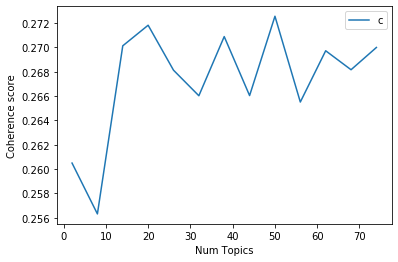

In [20]:
limit=80
start=2
step=6

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=list(final_df['3gram_reviews']), start=start, limit=limit, step=step)

# Show graph

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [21]:
LDA_01 = pyLDAvis.gensim.prepare(ldamodel1, corpus, dictionary)


C:\Users\Mancef\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


FileNotFoundError: [Errno 2] No such file or directory: '../supercase-airplane/viz/lda_01_raw.html'

In [22]:
pyLDAvis.save_html(LDA_01, '../supercase-airplane/viz/lda_01_raw.html')

In [23]:
coherence_values

[0.26049088935623654,
 0.25631348666044135,
 0.27012441536103315,
 0.2718154910450815,
 0.2681225350088591,
 0.26602190700299366,
 0.27088225869393723,
 0.26603576861423806,
 0.2725536249636692,
 0.2655057011964215,
 0.26971791951913215,
 0.2681589014487718,
 0.2699885495955092]

In [24]:
#build dictionary and corpus from 3gram dataset

documents = list(final_df['3gram_reviews'])
dictionary2 = gensim.corpora.Dictionary(documents)
corpus2 = [dictionary2.doc2bow(word) for word in documents]

In [25]:
# Trying 20 topics instead since it gives higher coherence

#LDA model parameters
num_topics = 20
passes = 100
eval_every = None #Evaluation will happen later so no need to evaluate while training

In [26]:
%time ldamodel2 = LdaMulticore(corpus2, num_topics=num_topics, id2word = dictionary2, passes=passes, alpha='asymmetric',eval_every=eval_every,workers=3)

# Check resulting topics.
topic_list = ldamodel2.print_topics(num_topics=num_topics, num_words=15)
for index, i in enumerate(topic_list):
    str1 = str(i[1])
    for c in "0123456789+*\".":
        str1 = str1.replace(c, "")
    str1 = str1.replace("  ", " ")
    print(str1)

Wall time: 7min 8s
bag not gate check tell ask flight wait airport do say be board staff the
Emirates Dubai flight staff airport the delay plane wait return via_Dubai time fly passenger service
BA British_Airways London Heathrow ba Club_Europe passenger LHR at_Heathrow London_Heathrow lose transfer Iberia lhr no
seat flight book pay change British_Airways upgrade fly BA not ticket economy business_class service business
not coach be do one use_them_again Prague hr credit in_front_of what meal a St_Lucia st
flight time the service Ryanair crew friendly aircraft fly return staff seat delay drink cabin_crew
flight pay ticket airport book Ryanair not charge check_in try refund airline the fee tell
the flight seat food service fly BA meal serve crew time offer drink Emirates not
time staff flight crew AA experience return fly friendly expect passenger travel Excellent_service F courtesy
flight delay American_Airlines plane time fly AA not the cancel airport get leave gate wait
Leeds que Kol

In [27]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel2.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda2 = CoherenceModel(model=ldamodel2, texts=documents, dictionary=dictionary2, coherence='c_v')
coherence_lda2 = coherence_model_lda1.get_coherence()
print('\nCoherence Score: ', coherence_lda2)


Perplexity:  -8.19037360512548

Coherence Score:  0.42146960601217065


In [28]:
pyLDAvis.enable_notebook()
vis = p_gensim.prepare(ldamodel2, corpus2, dictionary2)
vis

C:\Users\Mancef\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.101946  0.191221       1        1  26.391769
9      0.185698 -0.071407       2        1  18.465631
5      0.132101  0.122920       3        1   9.339199
0      0.159602 -0.122033       4        1   9.012918
6      0.183012 -0.144386       5        1   7.535046
3      0.118245 -0.027727       6        1   5.372725
12     0.128446 -0.029589       7        1   5.093472
1      0.126447  0.032080       8        1   4.211411
18     0.176092 -0.081067       9        1   4.057494
16     0.044845  0.140491      10        1   2.030711
2     -0.107323  0.041842      11        1   1.618355
13    -0.000219 -0.043947      12        1   1.543818
15    -0.034302  0.186115      13        1   1.319348
17    -0.074771  0.014005      14        1   0.999704
11    -0.049451 -0.039058      15        1   0.857066
8     -0.145053  0.049659      16        1   0.689498
4     -0.215693 -0.056089      17        1   0.452332
10    -0.244281 -0.044513      18        1   0.420095
19    -0.230726 -0.064350      19        1   0.329731
14    -0.254611 -0.054168      20        1   0.259677, topic_info=      Category          Freq               Term         Total  loglift  \
2474   Default   3032.000000                 BA   3032.000000  30.0000   
243    Default   7831.000000               seat   7831.000000  29.0000   
114    Default  10693.000000                the  10693.000000  28.0000   
7563   Default   3128.000000           Emirates   3128.000000  27.0000   
36     Default  19313.000000             flight  19313.000000  26.0000   
17084  Default   2085.000000              Dubai   2085.000000  25.0000   
2392   Default   1535.000000    British_Airways   1535.000000  24.0000   
14418  Default   2262.000000            Ryanair   2262.000000  23.0000   
344    Default   4413.000000            service   4413.000000  22.0000   
55     Default   4220.000000              plane   4220.000000  21.0000   
63     Default   5405.000000               time   5405.000000  20.0000   
26     Default   3088.000000              delay   3088.000000  19.0000   
333    Default   2702.000000          passenger   2702.000000  18.0000   
119    Default   2286.000000  American_Airlines   2286.000000  17.0000   
279    Default   2441.000000                pay   2441.000000  16.0000   
928    Default   2398.000000               crew   2398.000000  15.0000   
598    Default   3618.000000               food   3618.000000  14.0000   
103    Default   1512.000000               meal   1512.000000  13.0000   
725    Default   1369.000000             London   1369.000000  12.0000   
139    Default   1639.000000                 AA   1639.000000  11.0000   
16     Default   2162.000000                ask   2162.000000  10.0000   
108    Default   1616.000000              serve   1616.000000   9.0000   
732    Default   1713.000000                bag   1713.000000   8.0000   
52     Default   4980.000000                not   4980.000000   7.0000   
37     Default   5018.000000                fly   5018.000000   6.0000   
1762   Default   1775.000000              drink   1775.000000   5.0000   
39     Default   2075.000000               gate   2075.000000   4.0000   
18     Default   1795.000000              board   1795.000000   3.0000   
606    Default   3091.000000              staff   3091.000000   2.0000   
354    Default   1894.000000               wait   1894.000000   1.0000   
...        ...           ...                ...           ...      ...   
16396  Topic20      5.561533                Apr      9.773090   5.3897   
7541   Topic20      6.256012          carry_ons     13.385589   5.1929   
29985  Topic20      4.691457      Business_Plus      9.855677   5.2112   
12524  Topic20      3.323522              obese      7.127230   5.1906   
13152  Topic20      2.379590         contractor      4.772664   5.2575   
28950  Topic20      2.878390   

In [29]:
pyLDAvis.save_html(vis, '../supercase-airplane/viz/lda_02_raw.html')

In [30]:
ldamodel1.save('../supercase-airplane/lda/noclean_1.lda')

In [31]:
ldamodel2.save('../supercase-airplane/lda/noclean_2.lda')

# First Run in Summary

In my first run I had 10 topics and I was able to identify 5 generally coherent topics from the 10 provided.

Unfortunately, I have LOST them completely when I retrained the model after making some adjustments. 

These were the topics found and lost:

1. **Series Authenticity**</br>
(Topic 1) Game's authenticity compared to other titles in the Total War series (Important because target market is full of hardcore history/ROTK buffs)

2. **Strategic Gameplay**</br>
(Topic 2) Gameplay on the strategic scale, inclusive of new features e.g. revamped Diplomacy, Romance/Records mode selection

3. **Tactical Gameplay**</br>
(Topic 3) Gameplay of individual battles and managing individual cities

4. **Historical/Cultural Authenticity**</br>
(Topic 4) Game's authenticity compared to source material. Based on Records and Romance of the Three Kingdoms, historical records and a novel respectively.

5. **Faction/Character Playstyle**</br>
(Topics 6 and 7) Each faction and character has special abilities. Liu Bei appears a lot because he is written as a virtuous hero in Romance of the Three Kingdoms. Also, his special passive ability is extremely powerful. (=50% upkeep cost for militia units, so theoretically can field 2x the number of armies as any other faction)


### Minor issues
Problems from that first run that have been fixed in this final deployment notebook:
1. Make n-grams BEFORE lemmatisation and removal of numbers, to allow n-grams to include numbers. (Game names in the series can also then be identified)
2. Remove Chinese text; it appears in some of the other topics
3. Remove single-character text; it is unhelpful (e.g. i, u, x)
4. Remove low-frequency terms?

Minor fixes yet to be done:
1. Removal of low-frequency terms
2. Complete removal of single-character text (e.g. s above; sometimes cleaning and lemmatisation can leave such unwanted artifacts behind)

### Major issues
1. Generally low coherence of topics
2. Some topics share common terms despite having good topic separation (e.g. total_war)

### Solutions:
1. Change the types of words being allowed into the final dataset
    - Right now it includes all parts of speech
    - Will try a version with nouns only

2. Considering removing shared terms


### Not using TF-IDF

Decided not to use TF-IDF because "LDA is a probabilistic model that tries to estimate probability distributions for topics in documents and words in topics. The weighting of TF-IDF is not necessary for this."
Source: https://stackoverflow.com/a/44789327/6470915

Also, filter_extremes() can remove overly frequent/infrequent terms, thus serving a similar purpose.

### References

https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
https://stackoverflow.com/a/44789327/6470915